In [1]:
import os
import sys
import subprocess
import signac
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statistics import linear_regression
from scipy.stats import linregress
from pymser import pymser

In [56]:
def plot_res_pymser(job, eq_col, results, name, box_name):
    fig, [ax1, ax2] = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, sharey=True)

    ax1.set_ylabel(name, color="black", fontsize=14, fontweight='bold')
    ax1.set_xlabel("GEMC Steps", fontsize=14, fontweight='bold')

    ax1.plot(range(0, len(eq_col)*10, 10), 
            eq_col, 
            label = 'Raw data', 
            color='blue')

    ax1.plot(range(0, len(eq_col)*10, 10)[results['t0']:], 
            results['equilibrated'], 
            label = 'Equilibrated data', 
            color='red')

    ax1.plot([0, len(eq_col)*10], 
            [results['average'], results['average']], 
            color='green', zorder=4, 
            label='Equilibrated average')

    ax1.fill_between(range(0, len(eq_col)*10, 10), 
                    results['average'] - results['uncertainty'], 
                    results['average'] + results['uncertainty'], 
                    color='lightgreen', alpha=0.3, zorder=4)

    ax1.set_yticks(np.arange(0, eq_col.max()*1.1, eq_col.max()/10))
    ax1.set_xlim(-len(eq_col)*10*0.02, len(eq_col)*10*1.02)
    ax1.tick_params(axis="y", labelcolor="black")

    ax1.grid(alpha=0.3)
    ax1.legend()

    ax2.hist(eq_col, 
            orientation=u'horizontal', 
            bins=30, 
            edgecolor='blue', 
            lw=1.5, 
            facecolor='white', 
            zorder=3)

    bin_red = 10
    ax2.hist(results['equilibrated'], 
            orientation=u'horizontal', 
            bins=bin_red, 
            edgecolor='red', 
            lw=1.5, 
            facecolor='white', 
            zorder=3)

    ymax = int(ax2.get_xlim()[-1])

    ax2.plot([0, ymax], 
            [results['average'], results['average']],
            color='green', zorder=4, label='Equilibrated average')

    ax2.fill_between(range(ymax), 
                    results['average'] - results['uncertainty'],
                    results['average'] + results['uncertainty'],
                    color='lightgreen', alpha=0.3, zorder=4)

    ax2.set_xlim(0, ymax)

    ax2.grid(alpha=0.5, zorder=1)

    fig.set_size_inches(9,5)
    fig.set_dpi(100)
    fig.tight_layout()
    plt.show()
        #     save_name = 'MSER_eq_'+ box_name +'.png'
#     fig.savefig(job.fn(save_name), dpi=300, facecolor='white')
    plt.close(fig)
    return fig

In [57]:
def check_equil_converge(job, eq_data_dict, prod_tol, print_results=False):
    equil_matrix = []
    res_matrix = []
    prop_cols = [5]
    prop_names = ["Number of Moles"]
    try:
        # Load data for both boxes
        for key in list(eq_data_dict.keys()):
            eq_col = eq_data_dict[key]["data"]
            batch_size = max(1, int(len(eq_col) * 0.0005))

            # Try with ADF test enabled, fallback without it if it fails
            try:
                results = pymser.equilibrate(eq_col, LLM=False, batch_size=batch_size, ADF_test=True, uncertainty='uSD', print_results=False)
                adf_test_failed = results["critical_values"]["1%"] <= results["adf"]
            except:
                results = pymser.equilibrate(eq_col, LLM=False, batch_size=batch_size, ADF_test=False, uncertainty='uSD', print_results=False)
                results["adf"], results["critical_values"], adf_test_failed = None, None, False

            equilibrium = len(eq_col) - results['t0'] >= prod_tol
            equil_matrix.append(equilibrium and not adf_test_failed)
            res_matrix.append(results)

        # Log results
        # print("ID", job.id, "AT", job.sp.atom_type, "T", job.sp.T)
        # print(equil_matrix)
        # log_text = '==============================================================================\n'
        
        for i, is_equilibrated in enumerate(equil_matrix):
            # box = df_box1 if i < len(prop_cols) else df_box2
            # box_name = "Liquid" if i < len(prop_cols) else "Vapor"
            # col_vals = box[:, prop_cols[i % len(prop_cols)] - 1]
            key_name = list(eq_data_dict.keys())[i]
            box_name = key_name.rsplit("_", 1)[0]
            col_vals = eq_data_dict[key_name]["data"]
            #plot all

            if print_results and i ==0:
                plt = plot_res_pymser(job, col_vals, res_matrix[i], prop_names[i % len(prop_cols)], box_name)

                # Display outcome
                prod_cycles = len(col_vals) - res_matrix[i]['t0']
                if is_equilibrated:
                    #Plot successful equilibration
                    statement = f"       > Success! Found {prod_cycles} production cycles."
                else:
                    #Plot failed equilibration
                    statement = f"       > {box_name} Box Failure! "
                    if res_matrix[i]["adf"] is None:
                        # Note: ADF test failed to complete
                        statement += f"ADF test failed to complete! "
                    elif res_matrix[i]['adf'] > res_matrix[i]['critical_values']['1%']:
                        adf, one_pct = res_matrix[i]['adf'], res_matrix[i]['critical_values']['1%']
                        statement += f"ADF value: {adf}, 99% confidence value: {one_pct}! "
                    if len(col_vals) - res_matrix[i]['t0'] < prod_tol:
                        statement += f"Only {prod_cycles} production cycles found."
                    
                # with open("Equil_Output.txt", "a") as f:
                # print(statement)

    except Exception as e:
        #This will cause an error in the GEMC operation which lets us know that the job failed
        raise Exception(f"Error processing job {job.id}: {e}")
    
    return all(equil_matrix)

In [58]:
from pathlib import Path
def list_with_restarts(fpath):
    """List fpath and its restart versions in order as pathlib Path objects."""
    fpath = Path(fpath)
    if not fpath.exists():
        return []
    parent = fpath.parent
    fname = fpath.name
    fnamesplit = fname.split(".out.")
    run_name = fnamesplit[0]
    suffix = fnamesplit[1]
    restarts = [
        Path(parent, f)
        for f in sorted(list(parent.glob(run_name + ".rst.*.out." + suffix)))
    ]
    restarts.insert(0, fpath)  # prepend fpath to list of restarts
    return restarts



In [61]:
import glob
def process_old_job(jobs):
    "Run gemc"
    for job in jobs:
        prop_cols = [5] #Use number of moles to decide equilibrium
        # Load initial eq data from both boxes
        with job:
            fname1 = "gemc.eq" + ".out.log"
            list1 = list_with_restarts(fname1)
            list2 = list(list1[i].name.split(".out.")[0] for i in range(len(list1)))

            fname2 = "prod" + ".out.log"
            list3 = list_with_restarts(fname2)
            list4 = list(list3[i].name.split(".out.")[0] for i in range(len(list3)))
        try:
            with job:
                eq_data_dict = {}
                for i in range(len(list2)):
                    df_box1 = np.genfromtxt(job.fn(list2[i] + ".out.box1.prp"))
                    df_box2 = np.genfromtxt(job.fn(list2[i]  +  ".out.box2.prp"))
                    # Process both boxes in one loop
                    for b, box in enumerate([df_box1, df_box2]):
                        box_name = "Liquid" if b == 0 else "Vapor"
                        for prop_index in prop_cols:
                            #Get the key from the property and box name
                            key = f"{box_name}_{prop_index}"
                            # Extract the column data for this restart and append to accumulated data
                            eq_col_restart = box[:, prop_index - 1]
                            if i > 0:
                                eq_col_data = eq_data_dict[key]["data"]
                                all_eq_data = np.concatenate((eq_col_data, eq_col_restart))
                                eq_data_dict[key]["data"] = all_eq_data
                            else:
                                all_eq_data = eq_col_restart
                                eq_data_dict[key] = {"data": eq_col_restart}

                prod_data_dict = {}
                for i in range(len(list4)):
                    df_box3 = np.genfromtxt(job.fn(list4[i] + ".out.box1.prp"))
                    df_box4 = np.genfromtxt(job.fn(list4[i]  +  ".out.box2.prp"))
                    # Process both boxes in one loop
                    for b, box in enumerate([df_box3, df_box4]):
                        box_name = "Liquid" if b == 0 else "Vapor"
                        for prop_index in prop_cols:
                            #Get the key from the property and box name
                            key = f"{box_name}_{prop_index}"
                            # Extract the column data for this restart and append to accumulated data
                            prod_col_restart = box[:, prop_index - 1]
                            if i > 0:
                                prod_col_data = prod_data_dict[key]["data"]
                                all_prod_data = np.concatenate((prod_col_data, prod_col_restart))
                                prod_data_dict[key]["data"] = all_prod_data
                            else:
                                all_prod_data = prod_col_restart
                                prod_data_dict[key] = {"data": prod_col_restart}
                
                prod_tol_eq = int(eq_data_dict[key]["data"].size/4) 
                is_equilibrated_eq = check_equil_converge(job, eq_data_dict, prod_tol_eq)
                new_prod_tol = int(eq_data_dict[key]["data"].size*0.9)
                is_equilibrated_prod = check_equil_converge(job, prod_data_dict, new_prod_tol)
                # print(is_equilibrated_eq, is_equilibrated_prod)
                if is_equilibrated_eq and not is_equilibrated_prod:
                    print("ID", job.id, "T", job.sp.T, "rst", job.sp.restart)
                    check_equil_converge(job, eq_data_dict, prod_tol_eq, print_results=True)
                    check_equil_converge(job, prod_data_dict, new_prod_tol, print_results=True)
                
        except:
            pass
            print("Error processing job", job.id)


The results may not be reliable!
The results may not be reliable!
ID bc401f0ce6fcaa5c5927a4ddbda0c48b T 397.0 rst 1


/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/hfcs-fffit/lib/python3.11/site-packages/pymser/pymser.py:439: OptimizeWarning: Covariance of the parameters could not be estimated
  [tau], _ = curve_fit(exp_decay,  x,  ACF)
/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/hfcs-fffit/lib/python3.11/site-packages/pymser/pymser.py:439: OptimizeWarning: Covariance of the parameters could not be estimated
  [tau], _ = curve_fit(exp_decay,  x,  ACF)


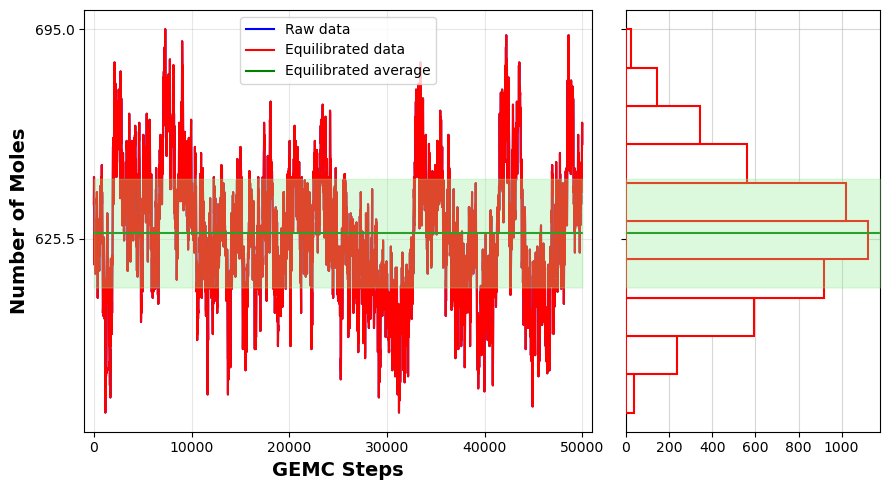

The results may not be reliable!
The results may not be reliable!


/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/hfcs-fffit/lib/python3.11/site-packages/pymser/pymser.py:439: OptimizeWarning: Covariance of the parameters could not be estimated
  [tau], _ = curve_fit(exp_decay,  x,  ACF)
/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/hfcs-fffit/lib/python3.11/site-packages/pymser/pymser.py:439: OptimizeWarning: Covariance of the parameters could not be estimated
  [tau], _ = curve_fit(exp_decay,  x,  ACF)


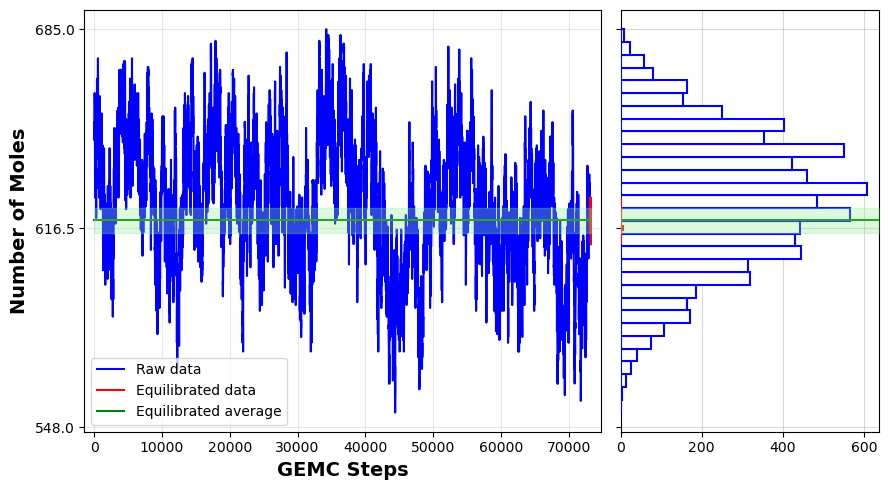

In [ ]:
import glob
mol_name = "R152a"
project = signac.get_project("gaff_ff_ms")
jobs = project.find_jobs({"mol_name": mol_name})
# jobs = project.find_jobs({"mol_name": mol_name, "restart": 1, "T":130})
# jobs = project.find_jobs()
# for job in jobs:
#     print(job.id)
process_old_job(jobs)